# Data Science Assignment

**Mateusz Wiza, IATSED21**

For this assignment, I have decided to analyze a dataset from Uber of a cohort of driver signups in January 2016. It may be used for predicting which driver signups are most likely to start driving. I will, therefore, train a classification model using the provided dataset as an input. 

Source: https://github.com/bjherger/Uber-DS-Challenge

## Table of Contents

* [1. Loading the Dataset](#ltd)
* [2. Data Analysis and Preparation](#dap)
* [3. Features Engineering](#fe)
    * [3.1. Target Variable](#tv)
    * [3.2. Features Extraction](#fe2)
    * [3.3. Multicolinearity Check](#mc)
* [4. Modeling](#m)
* [5. Conclusion](#c)

## 1. Loading the Dataset <a class="anchor" id="ltd"></a>

To perform any data analysis or modeling, first thing we need is the data. I will start with importing some useful libraries that I know I will use in this part. They include the Pandas and Numpy libraries for processing the dataset itself, as well as the vizualization libraries Matplotlib and Seaborn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

Using Pandas, we can load the dataset from a source CSV file and take a look into a sample of the data.

In [2]:
data = pd.read_csv('ds_challenge_v2_1_data.csv')

In [3]:
data.sample(10)

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
20421,20422,Strark,ios web,Organic,1/26/16,NaN,NaN,NaN,NaN,NaN,NaN
30142,30143,Strark,other,Paid,1/26/16,NaN,NaN,NaN,NaN,NaN,NaN
7815,7816,Strark,NaN,Referral,1/9/16,NaN,NaN,NaN,NaN,NaN,NaN
44770,44771,Strark,other,Referral,1/25/16,1/25/16,NaN,NaN,NaN,NaN,NaN
10924,10925,Strark,NaN,Organic,1/5/16,1/31/16,NaN,NaN,NaN,NaN,NaN
90,91,Strark,NaN,Referral,1/24/16,2/6/16,NaN,NaN,NaN,NaN,NaN
976,977,Berton,ios web,Referral,1/16/16,NaN,NaN,NaN,NaN,NaN,NaN
15065,15066,Berton,ios web,Referral,1/21/16,1/22/16,NaN,NaN,NaN,NaN,NaN
44257,44258,Strark,windows,Referral,1/7/16,1/8/16,1/30/16,Honda,Accord,2003.0,NaN
52333,52334,Strark,other,Organic,1/13/16,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Analysis and Preparation <a class="anchor" id="dap"></a>

Before defining any model, it makes sense to explore the data a little more and find out what changes we need to apply to them before the dataset can be used as an input for a classification model. 

We can start by observing the dimensions of the DataFrame containing the data.

In [4]:
data.shape

(54681, 11)

The dataset has a 11 variables (columns) and a little over 50.000 instances (rows). But are all the instances unique or are there entire rows that are duplicated? 

In [5]:
data = data.drop_duplicates()
data.shape

(54681, 11)

After applying a function to remove the duplicated rows from the dataset, its size has not changed which implies that there were no duplicated rows in the original dataset.

Next, we can take a look into the columns and the datatypes stored in them.

In [6]:
data.dtypes

id                        int64
city_name                object
signup_os                object
signup_channel           object
signup_date              object
bgc_date                 object
vehicle_added_date       object
vehicle_make             object
vehicle_model            object
vehicle_year            float64
first_completed_date     object
dtype: object

A problem that we can see right away is that there are four columns that are supposed to contain dates (`signup_date`, `bgc_date`, `vehicle_added_date` and `first_completed_date`) but these are stored as strings. Looking at the sample of data above, we can see that the dates are in a format `M/DD/YY` - it is not a particurarly Python-friendly format. Therefore, let's force these columns to a datetime format before proceeding.

In [7]:
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['bgc_date'] = pd.to_datetime(data['bgc_date'])
data['vehicle_added_date'] = pd.to_datetime(data['vehicle_added_date'])
data['first_completed_date'] = pd.to_datetime(data['first_completed_date'])

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54681 entries, 0 to 54680
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    54681 non-null  int64         
 1   city_name             54681 non-null  object        
 2   signup_os             47824 non-null  object        
 3   signup_channel        54681 non-null  object        
 4   signup_date           54681 non-null  datetime64[ns]
 5   bgc_date              32896 non-null  datetime64[ns]
 6   vehicle_added_date    13134 non-null  datetime64[ns]
 7   vehicle_make          13223 non-null  object        
 8   vehicle_model         13223 non-null  object        
 9   vehicle_year          13223 non-null  float64       
 10  first_completed_date  6137 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(5)
memory usage: 5.0+ MB


Displaying the information about the DataFrame suggests that the values in the date-like columns have indeed been converted into a datetime type. 

Another potential issue that we may see is that some columns have many NULL values. It's not necessary to deal with this issue right now but we may need to resolve it before using the data in a model.

---

Now, let's explore further individual variables, starting with `city_name`

Strark     29557
Berton     20117
Wrouver     5007
Name: city_name, dtype: int64


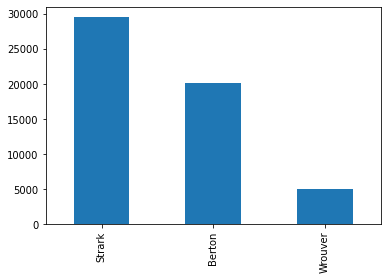

In [9]:
print(data['city_name'].value_counts())

data['city_name'].value_counts().plot.bar()
plt.show()

The drivers sign-ups in the dataset come from three cities: Stark, Berton and Wrouver. However, the distribution of sign-ups in these cities in not uniform and so Stark has significantly more records than Berton and Wrouver.

Next, let's take a look at `signup_os`:

ios web        16632
android web    14944
windows         6776
mac             5824
other           3648
Name: signup_os, dtype: int64


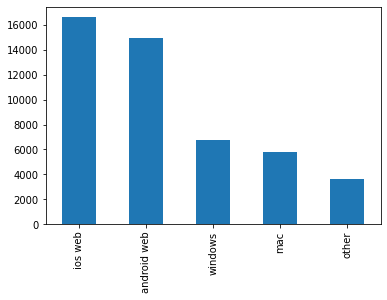

In [10]:
print(data['signup_os'].value_counts())

data['signup_os'].value_counts().plot.bar()
plt.show()

This categorical variable represents which operating system was used by a driver when they were signing up with Uber. We can see that most of them used a mobile OS such as IOS or Android with significant, yet smaller number of drivers, using Windows or Mac systems. There are also 3648 sign-ups for which the operating system is marked as 'Other'.

Are there any significant changes in these proportion when we take a look at different cities?

In [11]:
cities_and_os = data.groupby(by=['city_name', 'signup_os']).size().unstack()
cities_and_os

signup_os,android web,ios web,mac,other,windows
city_name,,,,,
Berton,5157,6669,2308,1361,2611
Strark,8546,8405,2988,1759,3364
Wrouver,1241,1558,528,528,801


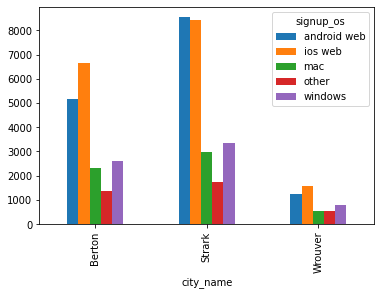

In [12]:
cities_and_os.plot.bar()
plt.show()

The differences are there but are not large. For instance, most drivers in Stark signed up on an Android device while in other cities it's the IOS with the majority of sign-ups.

What about the sign-up channel, represented by the variable `signup_channel`?

Paid        23938
Referral    17316
Organic     13427
Name: signup_channel, dtype: int64


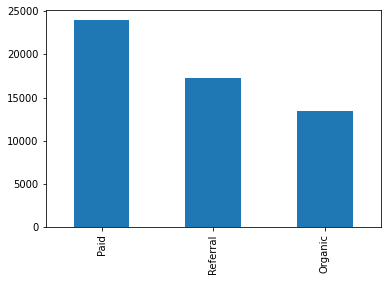

In [13]:
print(data['signup_channel'].value_counts())

data['signup_channel'].value_counts().plot.bar()
plt.show()

This variable takes 3 values: Paid, Referral and Organic. There is no clear definition of these three channels but we can assume that this explains in what way drivers were directed towards the sign-up. Again, the distribution of sign-ups across different channels in not uniform - some channels have more sign-ups than the others.

In [14]:
cities_and_channels = data.groupby(by=['city_name', 'signup_channel']).size().unstack()
cities_and_channels

signup_channel,Organic,Paid,Referral
city_name,,,
Berton,4841,8741,6535
Strark,7283,12407,9867
Wrouver,1303,2790,914


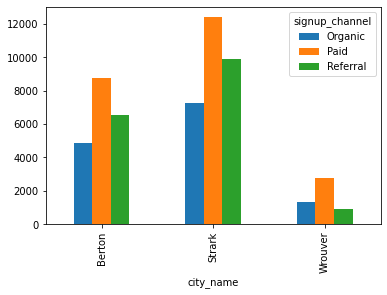

In [15]:
cities_and_channels.plot.bar()
plt.show()

The proportion of sign-up channels is similar in all three cities with a small exception that in Wrouver the 'Organic' sign-ups are more common than the 'Referral' ones.

---

Now, let's take a closer look at the date-like columns, starting with observing a range of dates in each of them.

In [16]:
print('Sign-up date:')
print('Min:', data['signup_date'].min().date(), ' |  Max:', data['signup_date'].max().date())
print('Background check date:')
print('Min:', data['bgc_date'].min().date(), ' |  Max:', data['bgc_date'].max().date())
print('Vehicle added date:')
print('Min:', data['vehicle_added_date'].min().date(), ' |  Max:', data['vehicle_added_date'].max().date())
print('First trip date:')
print('Min:', data['first_completed_date'].min().date(), ' |  Max:', data['first_completed_date'].max().date())

Sign-up date:
Min: 2016-01-01  |  Max: 2016-01-30
Background check date:
Min: 2016-01-01  |  Max: 2016-03-25
Vehicle added date:
Min: 2016-01-01  |  Max: 2016-03-26
First trip date:
Min: 2016-01-04  |  Max: 2016-02-29


We were informed that the data concern a January 2016 cohort of drivers and this checks out - all the drivers in the dataset signed up between January 1st and 30th, 2016. However, the dates concerning their further steps in the company (background check, adding a vehicle and starting driving) typically happen after a sign-up. Therefore, the other dates spread into the other months and there are drivers who signed-up in January but, for example, added a vehicle on March 26th, 2016.

Since the sign-up dates come from a single month, we can quickly generate a histogram of many sign-ups happened on each day using the day of the month extracted from the date:

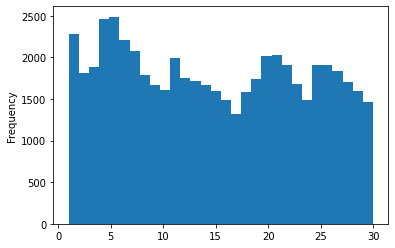

In [17]:
data['signup_date'].dt.day.plot.hist(bins=30)
plt.show()

We can see that there were generally more sign-ups in the first days of the month than in the last ones. Especially, the first 7 or so days have seen many sign-ups. The numbers are also not spread uniformly and seem to show some kind of weekly patterns.

For the other dates, let's approach it differently. We can calculate how many days after the sign-up each driver had the background check, added a vehicle and started driving, and we can observe the distributions of these values.

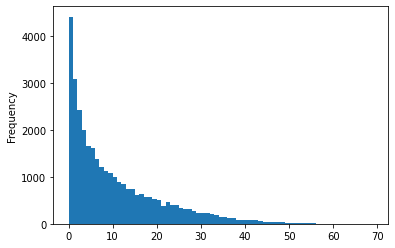

Total background checks: 32896


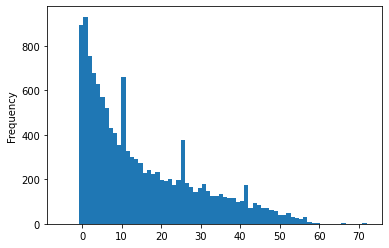

Total vehicles added: 13134


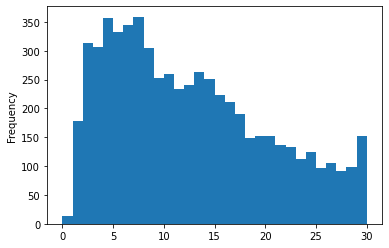

Total first trips: 6137


In [18]:
diff_signup_bgc = data['bgc_date'] - data['signup_date']
diff_signup_bgc = diff_signup_bgc.dropna()
diff_signup_bgc.dt.days.plot.hist(bins=diff_signup_bgc.dt.days.max())
plt.show()
print('Total background checks:', diff_signup_bgc.shape[0])

diff_signup_vehicle = data['vehicle_added_date'] - data['signup_date']
diff_signup_vehicle = diff_signup_vehicle.dropna()
diff_signup_vehicle.dt.days.plot.hist(bins=diff_signup_vehicle.dt.days.max())
plt.show()
print('Total vehicles added:', diff_signup_vehicle.shape[0])

diff_signup_trip = data['first_completed_date'] - data['signup_date']
diff_signup_trip = diff_signup_trip.dropna()
diff_signup_trip.dt.days.plot.hist(bins=diff_signup_trip.dt.days.max())
plt.show()
print('Total first trips:', diff_signup_trip.shape[0])

There are two main findings we can make here. The first is that the distributions look largely different for the different events. Both background check and adding the vehicle distributions are largely skewed to the left. In other words, the majority of drivers have both events right after the sign-up and the more days ellapse, the less drivers complete the background check or add a vehicle. However, there seems to be an anomaly with adding the vehicle, there are sudden spikes in the number of drivers who complete this step starting on the 11th day after the sign-up and then occuring every 15 days. This could be explained, for exmample by Uber sending e-mail reminders on a given number of days after a sign-up reminding the drivers to add a vehicle and that's why many drivers complete this step at the same time.

At the same time, the distribution of delay to making the first trip from a sign-up is largely different from the other two. First, most drivers seem to wait approximately one week from the sign-up before making the first trip. Then, the more days ellapse, the less drivers make their first trip but this number is not decreasing fast. A significant proportions of drivers complete their trip even 30 days after they sign up. At the same time, 30 days in the longest delay - we don't know if this is by chance or if, for example, after 30 days without a trip, Uber considers an account inactive and switches it off.

The other finding is that the number of drivers who complete the next steps decreases. Out of 54.681 sign-ups in the dataset, only 6137 drivers complete their first trip. The manner in which the numbers decrease also suggests a certain pipeline or a logical ordering of these events: first is a sign up, then drivers complete a background check, then they add a vehicle and then make the first trip. At each step, at the same time, there is a significant churn of sign-ups. Let's further investicate this pipeline as this is the core of this analysis.

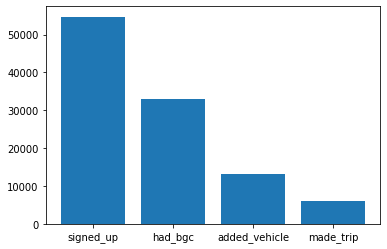

Sign-ups who started driving: 11.22 %
Drivers with BGC who started driving: 18.66 %
Drivers who added vehicle that started driving: 46.73 %


In [19]:
all_signups = data['signup_date'].dropna().shape[0]
n_bgc = diff_signup_bgc.shape[0]
n_vehicle = diff_signup_vehicle.shape[0]
n_trip = diff_signup_trip.shape[0]

plt.bar(['signed_up', 'had_bgc', 'added_vehicle', 'made_trip'], height=[all_signups, n_bgc, n_vehicle, n_trip])
plt.show()

print('Sign-ups who started driving:', round(n_trip / all_signups * 100, 2), '%')
print('Drivers with BGC who started driving:', round(n_trip / n_bgc * 100, 2), '%')
print('Drivers who added vehicle that started driving:', round(n_trip / n_vehicle * 100, 2), '%')

Slightly more than a half of sign-ups complete their background checks but, out of those, less than half actually add a vehicle and even less (18.66%) start driving. All in all, only 11.22% of drivers who sign up end up having a first trip. At the same time, almost half of the drivers who add a vehicle, end up completing a first trip.

But this pipeline and the fact that in order to move on to the next event, a driver must complete a previous one, is still only our assumption. So let's verify if this assumption is correct.

In [20]:
print('Drivers who made first trip but have no sign-up date:')
print(data[~(data['first_completed_date'].isna()) & data['signup_date'].isna()].shape[0])
print('Drivers who made first trip but have no BGC date:')
print(data[~(data['first_completed_date'].isna()) & data['bgc_date'].isna()].shape[0])
print('Drivers who made first trip but have no vehicle added date:')
print(data[~(data['first_completed_date'].isna()) & data['vehicle_added_date'].isna()].shape[0])

Drivers who made first trip but have no sign-up date:
0
Drivers who made first trip but have no BGC date:
0
Drivers who made first trip but have no vehicle added date:
265


It seems that indeed, all drivers who completed their first trip have signed up and completed a background check so these are likely compulsory steps. However, it seems that it is possible to complete a first trip without adding a vehicle, however, this situation only concerns 4% of drivers who start driving.

---

Now, let's also take a look at the data about the type of vehicle:

In [21]:
print('Number of unique makes:', data['vehicle_make'].value_counts().shape[0])
print('Number of unique models:', data['vehicle_model'].value_counts().shape[0])
print('Average number of models per make:', round(data.groupby('vehicle_make').nunique()['vehicle_model'].mean(), 2))

Number of unique makes: 46
Number of unique models: 368
Average number of models per make: 8.02


In [22]:
data.groupby('vehicle_make')['vehicle_model'].agg(['count', 'nunique']).sort_values(by='count', ascending=False).rename(columns={'count': 'frequency', 'nunique': 'n_models'})

,frequency,n_models
vehicle_make,,
Toyota,3219,21
Honda,1845,13
Nissan,1311,16
Ford,778,26
Hyundai,677,13
Chevrolet,665,30
Kia,584,13
Volkswagen,503,14
Dodge,393,15


This doesn't provide us with much insight except of the fact that there is quite a high variation in vehicle makes and models, and that these categorical variables take on many unique values.

We can also plot the distribution of the year of the drivers' vehicles:

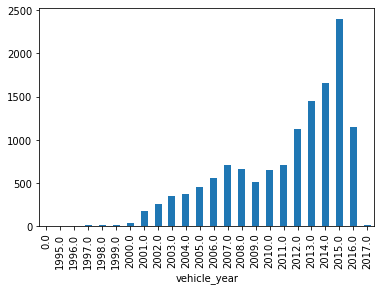

In [23]:
data.groupby('vehicle_year').size().plot.bar()
plt.show()

## 3. Features Engineering <a class="anchor" id="fe"></a>

After completing the data analysis, we can move closer to the modeling task by defining and processing the features. Currently, we have a mix of numbers, dates, strings and NULL values in the dataset but for the model we only want numerical features. Fortunately, we can extract numerical features from the current variables.

### 3.1. Target Variable <a class="anchor" id="tv"></a>

**discussion about what is the target**

First, we need to extract the most important - the target variable that our model will need to predict. We want to predict if a sign-up will start driving. This is a binary classification task and so our target variable will be a Boolean indicating whether, for a given sign-up, there exists a date of the first trip. Since we need to the variable to be numerical, the Boolean will take the values (0, 1) instead of (False, True).

In [24]:
# Get the Boolean if the date exists
data['starts_driving'] = ~(data['first_completed_date'].isna())
# Map the True/False values to (1,0)
data['starts_driving'] = data['starts_driving'].astype(int)

### 3.2.  Features Extraction <a class="anchor" id="fe2"></a>

#### Dates

Next, we can extract the actual features or the input variables. First, we can use the fact that all sign-up dates are from the same month and simply extract the day of the month as a feature. After all the information about the month and year is the same in all rows in this case so we can easily skip it. Additionally, since we saw what could've been weekly patterns, we can extract a weekday number from the same date and use it as additional feature.

In [25]:
data['signup_day'] = data['signup_date'].dt.day
data['signup_weekday'] = data['signup_date'].dt.weekday 

For the other dates, since these aren't necessarily from the same month, we can use another approach and, similar to what we have done in the data analysis, extract the delay, in days between different dates. We will have the number of days ellapsed from the sign-up until background check, from sign-up to adding a vehicle and from beckground check to adding a vehicle.

Apart from this, we can also add Boolean variables, again in a (0,1) format, indicating if a driver even has completed a given step such as the background check or adding a vehicle.

In [26]:
data['had_bgc'] = ~(data['bgc_date'].isna())
data['had_bgc'] = data['had_bgc'].astype(int)
data['bgc_delay'] = (data['first_completed_date'] - data['signup_date']).dt.days

data['added_vehicle'] = ~(data['vehicle_added_date'].isna())
data['added_vehicle'] = data['added_vehicle'].astype(int)
data['vehicle_delay_signup'] = (data['vehicle_added_date'] - data['signup_date']).dt.days
data['vehicle_delay_bgc'] = (data['vehicle_added_date'] - data['bgc_date']).dt.days

The issue with the variables based on the days ellapsed between events is that when either date is not in the dataset, the resulting difference is also a NULL value. For the model, however, we shouldn't have these. We also don't want to remove all these rows and it's quite important if some drivers didn't complete some other steps of the process.

One solution is to replace these NULL values with some numeric values. We can, for example, imagine that if a driver hasn't completed a background check or added a vehicle, it's possible that they actually did it so late that it's not captured in the dataset. Using this logic, it wouldn't be far-fetched if we replace the NULL values with some arbitrary high value, higher than the highest delay captured in the dataset, e.g. 100 days. Hopefully, in combination with the Boolean variables that indicate whether the date even exists in the data, our model will be able to deal with such an approach. 

In [27]:
data['bgc_delay'] = data['bgc_delay'].fillna(100)
data['vehicle_delay_signup'] = data['vehicle_delay_signup'].fillna(100)
data['vehicle_delay_bgc'] = data['vehicle_delay_bgc'].fillna(100)

#### Categorical features

Now, we can move on to the categorical data, i.e. the ones with text or strings. There are, essentially, two main approaches when it comes to converting categorical variables to numerical features. We could assign a number for each distinct value that a feature takes. This however, would create numerical spectra without the coverage in the real world. For instance, if we assign values 1, 2 and 3 to our three city names, this would imply that the city that gets value 2 is somehow in between the other cities. This, in turn, could reduce the accuracy of linear models.

Therefore, I will use the other approach that involves converting the categorical features into so-called dummy variables. What this means in practice is that for each unique value from a categorical variable, we will add a new Boolean variable indicating whether a row has this very value of a categorical variable or not. In Pandas, this can be achieved quickly using the `get_dummies()` function.

In [28]:
city_dummy = data['city_name'].str.get_dummies()
os_dummy = data['signup_os'].str.get_dummies()
channel_dummy = data['signup_channel'].str.get_dummies()

data = pd.concat([data, city_dummy, channel_dummy, os_dummy], axis=1)
data

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,...,Strark,Wrouver,Organic,Paid,Referral,android web,ios web,mac,other,windows
0,1,Strark,ios web,Paid,2016-01-02,NaT,NaT,NaN,NaN,NaN,...,1,0,0,1,0,0,1,0,0,0
1,2,Strark,windows,Paid,2016-01-21,NaT,NaT,NaN,NaN,NaN,...,1,0,0,1,0,0,0,0,0,1
2,3,Wrouver,windows,Organic,2016-01-11,2016-01-11,NaT,NaN,NaN,NaN,...,0,1,1,0,0,0,0,0,0,1
3,4,Berton,android web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016.0,...,0,0,0,0,1,1,0,0,0,0
4,5,Strark,android web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016.0,...,1,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54676,54677,Strark,other,Paid,2016-01-15,NaT,NaT,NaN,NaN,NaN,...,1,0,0,1,0,0,0,0,1,0
54677,54678,Strark,other,Paid,2016-01-21,NaT,NaT,NaN,NaN,NaN,...,1,0,0,1,0,0,0,0,1,0
54678,54679,Strark,ios web,Organic,2016-01-06,NaT,NaT,NaN,NaN,NaN,...,1,0,1,0,0,0,1,0,0,0
54679,54680,Berton,android web,Paid,2016-01-18,NaT,NaT,NaN,NaN,NaN,...,0,0,0,1,0,1,0,0,0,0


In this way, we have converted the `city_name`, `signup_os` and `signup_channel` to dummy variables. We also have the categorical variables regarding the vehicle but these are more problematic. The issue is that there is just too many unique values in these columns and they repeat rather rarely. Converting them to dummy viariables would thus create a huge number of additional and very sparse features. One solution could be to perform some data fusion with a publicly available dataset of cars, try to match the combinations of types and makes from our dataset and in this way extract additional features such as e.g. the price of the car. In this analysis, however, I have decided not to include these two variables especially that, also logically speaking, the make and type of a vehicle probably have little influence on the fact if a driver will start driving. 

However, we can still use the `vehicle_year` variable as it is already a numerical feature. Well, almost, because it contains a lot of NULL values for the majority of the instances. It is also difficult to find a logical value to replace these NULLs with. We could use -1 or 0 but the this would largely increase the range of values in this feature which usually is a bad idea. Therefore, I changed this feature to the age of the car (difference between the year 2016 and the year when the car was made) and the instances where `vehicle_year` is NULL get assigned a value of -1. 

In [29]:
def get_vehicle_age(year):
    if pd.isna(year):
        return -1
    else:
        return 2016 - year

data['vehicle_age'] = data.apply(lambda row: get_vehicle_age(row['vehicle_year']), axis=1)
data[['vehicle_year', 'vehicle_age']].sample(10)

,vehicle_year,vehicle_age
43709,2014.0,2.0
45049,2013.0,3.0
17770,NaN,-1.0
29913,NaN,-1.0
17251,NaN,-1.0
44727,NaN,-1.0
46516,NaN,-1.0
12173,NaN,-1.0
36516,NaN,-1.0
53814,NaN,-1.0


Now, we can select the final features that will be used in our model and verify that these are indeed all numeric.

In [30]:
final_data = data[['starts_driving', 'signup_day', 'signup_weekday', 'had_bgc', 'bgc_delay', 
                   'added_vehicle', 'vehicle_delay_signup', 'vehicle_delay_bgc', 'vehicle_age', 
                   'Berton', 'Strark', 'Wrouver', 'Organic', 'Paid', 'Referral', 'android web', 
                   'ios web', 'mac', 'windows']]
print(final_data.shape)
print(final_data.dtypes)
final_data.sample(5)

(54681, 19)
starts_driving            int32
signup_day                int64
signup_weekday            int64
had_bgc                   int32
bgc_delay               float64
added_vehicle             int32
vehicle_delay_signup    float64
vehicle_delay_bgc       float64
vehicle_age             float64
Berton                    int64
Strark                    int64
Wrouver                   int64
Organic                   int64
Paid                      int64
Referral                  int64
android web               int64
ios web                   int64
mac                       int64
windows                   int64
dtype: object


,starts_driving,signup_day,signup_weekday,had_bgc,bgc_delay,added_vehicle,vehicle_delay_signup,vehicle_delay_bgc,vehicle_age,Berton,Strark,Wrouver,Organic,Paid,Referral,android web,ios web,mac,windows
5385,0,28,3,1,100.0,0,100.0,100.0,-1.0,1,0,0,0,0,1,0,1,0,0
23948,0,5,1,1,100.0,0,100.0,100.0,-1.0,1,0,0,0,1,0,1,0,0,0
41261,0,9,5,1,100.0,0,100.0,100.0,-1.0,0,1,0,1,0,0,0,0,1,0
46712,0,7,3,1,100.0,0,100.0,100.0,-1.0,1,0,0,0,0,1,0,0,0,1
44163,0,8,4,1,100.0,0,100.0,100.0,-1.0,0,1,0,0,1,0,1,0,0,0


As we can see, we now have 19 variables (18 features and 1 binary target variable) - all of them being numerical.

### 3.3. Multicolinearity Check <a class="anchor" id="mc"></a>

Before proceeding, we can still check for multicolinearity among our features since it can influence the performance of some models. We will check it by computing a Variance Inflation Factor (VIF) of each variable.

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# compute VIF score with variance_inflation_factor() function
def compute_vif(features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(final_data[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

# apply VIF computation to all columns
features = final_data.columns.to_list()
vif_data = compute_vif(features)
vif_data

C:\Users\mateu\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,signup_weekday,1.009523
1,vehicle_age,1.026443
2,signup_day,1.037899
3,had_bgc,1.312678
4,mac,1.478806
5,windows,1.560272
6,android web,1.920943
7,ios web,1.956118
8,vehicle_delay_bgc,35.431835
9,added_vehicle,47.355684


There is quite a lot of features with high VIF values. This indicates high multicollinearity or our features set. To repair this, we can remove some features. We'll start by removing a feature with the highest VIF value, then recompute the score before removing the next feature. We will continue this process until all feature have a VIF score below 20. (this is arbitrary choice).

In [32]:
# drop with highest vif score until all vif scores are under 20
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("I will remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data

I will remove Berton
I will remove Paid
I will remove bgc_delay
I will remove vehicle_delay_signup


,feature,VIF
0,vehicle_age,1.026981
1,Wrouver,1.257200
2,Organic,1.640217
3,mac,1.641575
4,windows,1.758380
5,starts_driving,1.789475
6,Referral,2.008378
7,Strark,2.460871
8,android web,2.602042
9,ios web,2.765154


The process has removed 4 features. By looking at which ones these were, we can understand why multicollinearity has occured. For example, one of the dummy_variables for the city name has been removed. This is because we already have two other features for the two other city names and if the values in both of these columns are 0, then it implies a row being from the third city.

Finally, we can plot the correlation diagram of the final set of features.

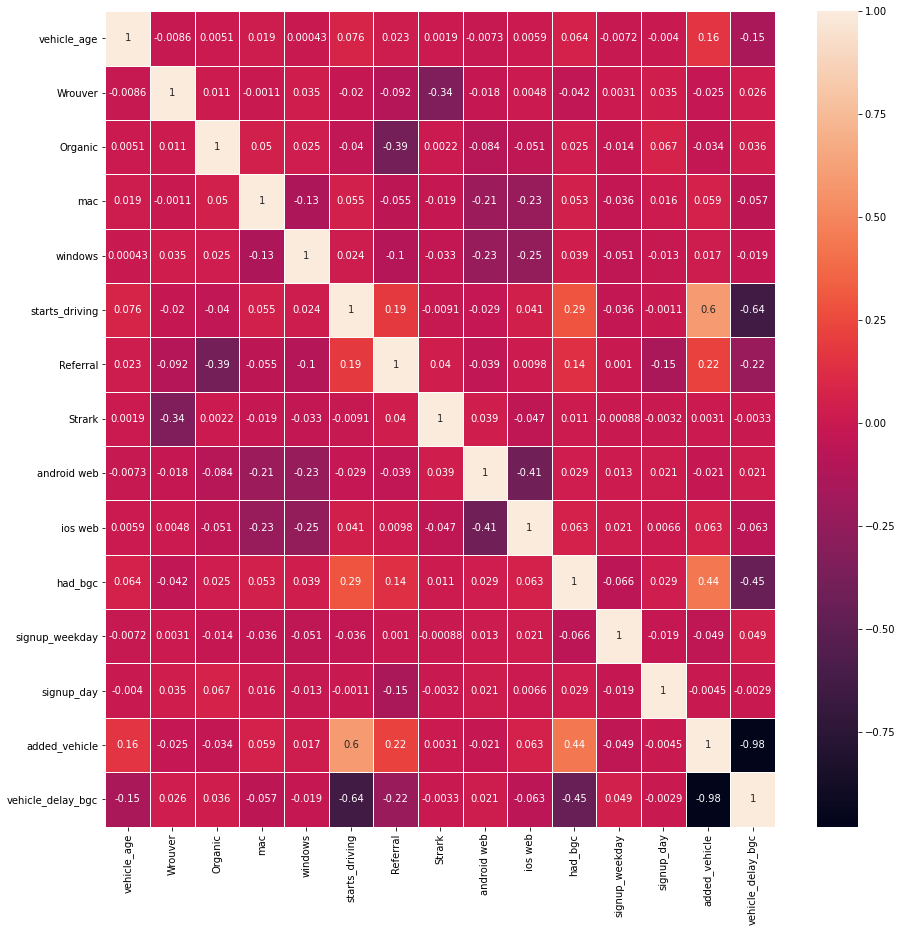

In [33]:
# correlation matrix of multicollinearity free dataset
plt.figure(figsize=(15, 15)) # width and height in inches
sns.heatmap(final_data[selected_features].corr(), annot=True, lw=1)
plt.show()

## 4. Modeling <a class="anchor" id="m"></a>

Now that the data have been prepared, we can use them to define a predictive model. 

First, we need to split the dataset into a training and test sets. I decided to do it in 75%/25% proportions.

Because of the significant class imbalance in the target variable (only 11% of sign-ups started driving), I'm performing a stratified train/test split to ensure the good representation of the two classes of the target variable in both sets. 

In [34]:
from sklearn.model_selection import train_test_split

model_data = final_data[selected_features]

Y = np.array(model_data['starts_driving'])
X = np.array(model_data.drop('starts_driving', axis=1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.25, random_state=42)

Since the different features in our dataset have verrying range (some are binary while some stretch from 0 to 100), it's a good practice to scale the input variables. I will use a MinMaxScaler from the sklearn library that will map all the features to a (0,1) space.

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now, we can actually select the models. I decided to train a selection of very popular classification models and compare their performance. The implementation of all the models comes from the sklearn library. The models I selected are:

- Logistic regression - similar to linear regression, but adapted to classification via using the logit function. Amazon have an extensive [tutorial](https://aws.amazon.com/what-is/logistic-regression/) on logistic regression.
- Decision tree classifier - builds a single decision tree, where each node is a decision concerning the level of one of the features, to most accurately capture the conditions determining each output class
- Random forest classifier - an algorithm constructing a number of decision trees, each time reshuffling the data using bootstrap technique, and determining the final prediction based on the weighted average of the resuls of all the trees
- Gradient boosting classifier - similar to random forest but the next decision trees are built consecutively, each time using the knowledge from the previous decision tree
- Support vector machine - similar to logistic regression but instead of finding a linear function in the feature space to best split the target instance per class, the SVM tries to establish the largest possible linear buffer between the different classes
- Stochastic gradient descent classifier - an algorithm that uses gradient descent to learn regularized linear classifiers
- k-NN (Nearest Neighbours) - instance based learning algorithm that uses majority voting of its __k__ nearest neighbors (most similar instances from the training set) to classify a new instance

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

names = [
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "Gradient Boosting",
    "SVM",
    "SDG",
    "KNN"
]

classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(random_state=18),
    RandomForestClassifier(random_state=32),
    GradientBoostingClassifier(random_state=74),
    svm.SVC(),
    SGDClassifier(),
    KNeighborsClassifier()
]

I will train these models using their default parameters and the training sets. We can then evaluate the models using a test set and the following metrics:

- Accuracy - the number of correct predictions divided by the total number of predictions
- F1 score - the harmonic mean of precision and recall, where:
    - Precision - the number of true positive predictions divided by the number of all correct predictions
    - Recall - the number of true positive predictions divided by the number of all relevant items (true positive and false negatives)

In [37]:
from sklearn.metrics import f1_score

for name, clf in zip(names, classifiers):
    clf.fit(X_train_scaled, Y_train)
    acc_score = clf.score(X_test_scaled, Y_test)
    Y_pred = clf.predict(X_test_scaled)
    f_score = f1_score(Y_test, Y_pred, average='macro')
    print("accuracy:", "{:.2f}".format(acc_score), "f1_score:", "{:.2f}".format(f_score), "Model:", name)

accuracy: 0.92 f1_score: 0.81 Model: Logistic Regression
accuracy: 0.90 f1_score: 0.75 Model: Decision Tree
accuracy: 0.92 f1_score: 0.78 Model: Random Forest
accuracy: 0.93 f1_score: 0.82 Model: Gradient Boosting
accuracy: 0.92 f1_score: 0.80 Model: SVM
accuracy: 0.92 f1_score: 0.80 Model: SDG
accuracy: 0.90 f1_score: 0.76 Model: KNN


The accuracies are very high which may suggest that our model do very well in the prediction task. However, there is a potential issue that we must consider. It has to do with class imbalance. Remember that we're predicting if sign-ups will start driving and only 11% of sign-ups in the dataset do. Therefore, if we had a very simple "model" that would only assign False predictions to all cases, it would still be correct in 89% of cases. 

So, to check if this is really a problem, we can observe the F1 score separately for the both classes of the target variable:

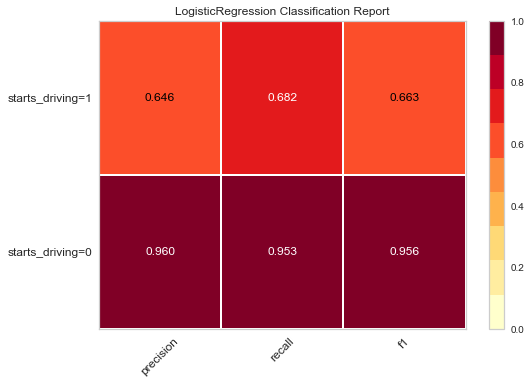

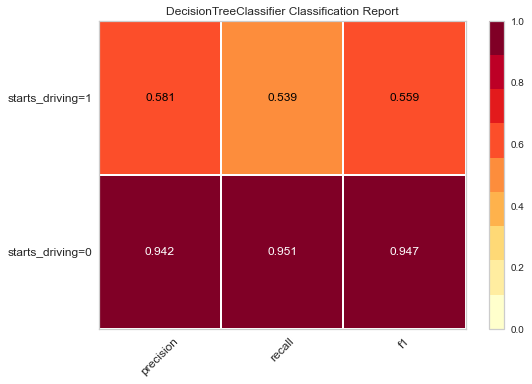

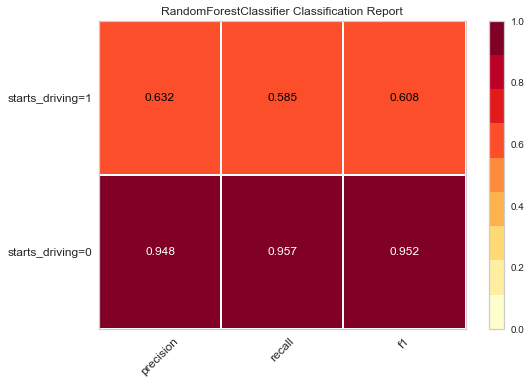

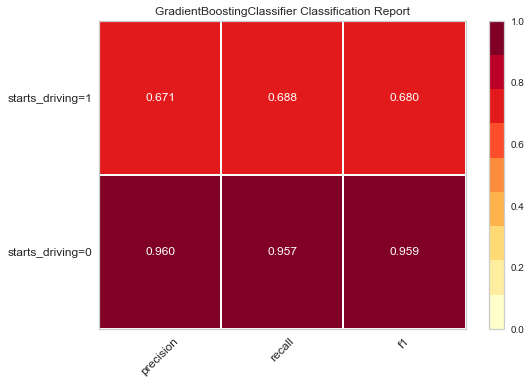

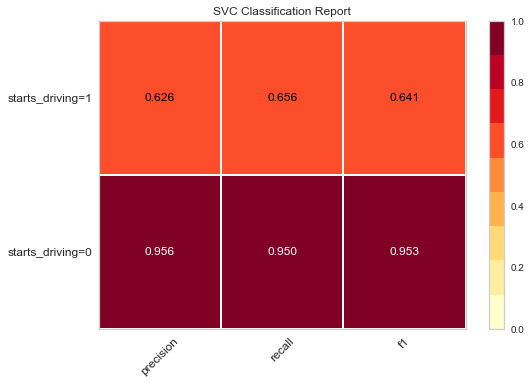

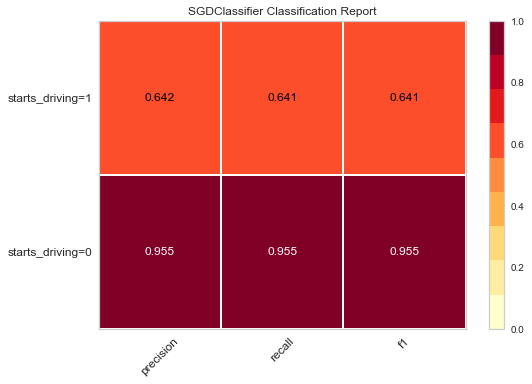

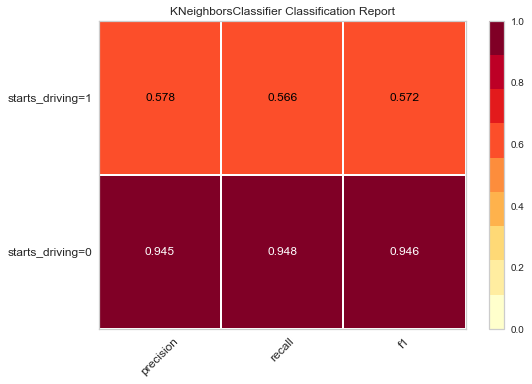

In [38]:
from yellowbrick.classifier import ClassificationReport

for name, clf in zip(names, classifiers):
    visualizer = ClassificationReport(clf, classes=["starts_driving=0", "starts_driving=1"])
    visualizer.fit(X_train_scaled, Y_train)
    visualizer.score(X_test_scaled, Y_test)
    visualizer.show()

As we can see, most models struggle a lot when predicting the True label simply because of the class imbalance and how few, in comparison with the outcome, such instances there are. Still, the tree-based Gradient Boosting Classifier seems to perform very well for both classes. 

Based on all this information, we may want to select the Gradient Boosting Classifier as the right model for this task.

## 5. Conclusion <a class="anchor" id="c"></a>

In the end, we have managed to find a rather accurate model for predicting if Uber sign-ups from 2016 would start driving. Hypothetically, if Uber had access to such a model, they could use it to better allocate resources (e.g. spend more on onboarding of the drivers who are more likely to start driving), to better estimate how many drivers will there be in the system after a certain time period or to make a decision to better support the drivers who are less likely to start driving with a hope to reverse the trend.

The main disadvantage of this model seems to be the fact that it uses multiple features that describe the driver's behaviour after their sign-up. We're looking for example at facts such as if they complete a background check or how old is their car but in some cases we may only find out about these facts up to 30 days after sign-up when it may well be already clear if the driver starts driving or not. A possible solution could be splitting this model into two: first we would try to make the prediction based solely on the sign-up date but this will likely not be very accurate. Then, we can only consider drivers who already had a background check and added a vehicle, and predict who of those will start driving (after all, it's only ~50%). But these specific choices would depend on the business targets and it would need to be executives in the company to decide these.

Coming back to our model, we could further improve its performance by applying parameters tunning on the best performing model or by addressing the issue of class imbalance (e.g. via resampling of the target variable using SMOTE or bootstrapping). In theory, we could also try implementing a more advanced nerual-network-based model but given the already good performance of the classic ML models and the size of the dataset (35.000 instances in training set), I highly doubt the neural network would significantly outperform the random forest classifier.